# Relax Challenge

Tamara Monge

### 1. Importing

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
from time import time
from datetime import datetime, date, timedelta
import calendar
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline 

# supervised learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score   
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Import datasets
df1 = pd.read_csv('takehome_users.csv', header=0, parse_dates=True, encoding = 'ISO-8859-1')
df2 = pd.read_csv('takehome_user_engagement.csv', header=0, parse_dates=True)

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


### 2. Wrangling

In [5]:
# Join tables on user_id
df = df2.merge(right=df1, how='outer', left_on='user_id', right_on='object_id')
df.drop(['user_id', 'last_session_creation_time'], axis=1, inplace=True)
# Examine merged dataframe
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211094 entries, 0 to 211093
Data columns (total 11 columns):
time_stamp                    207917 non-null object
visited                       207917 non-null float64
object_id                     211094 non-null int64
creation_time                 211094 non-null object
name                          211094 non-null object
email                         211094 non-null object
creation_source               211094 non-null object
opted_in_to_mailing_list      211094 non-null int64
enabled_for_marketing_drip    211094 non-null int64
org_id                        211094 non-null int64
invited_by_user_id            118528 non-null float64
dtypes: float64(2), int64(4), object(5)
memory usage: 19.3+ MB


,time_stamp,visited,object_id,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,2014-04-22 03:53:30,1.0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803.0
1,2013-11-15 03:45:04,1.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0
2,2013-11-29 03:45:04,1.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0
3,2013-12-09 03:45:04,1.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0
4,2013-12-25 03:45:04,1.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316.0


In [6]:
# Deal with missing data by setting to 0
df['invited_by_user_id'].fillna(0, inplace=True) 
df['time_stamp'].fillna(0, inplace=True)
df['visited'].fillna(0,inplace=True)

df1['invited_by_user_id'].fillna(0, inplace=True) 

In [7]:
# Set datetime objects 
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
df['creation_time'] = pd.to_datetime(df['creation_time'])

In [8]:
# Sort values by user and timestamp, set index to user
df.sort_values(['object_id', 'time_stamp']).set_index(['object_id'], inplace=True)

### 3. Feature Engineering

In [9]:
# Determine how many users adopted
(df.groupby('object_id')['time_stamp'].count() >= 3).sum()

2248

In [10]:
start = time()
# Initialize adopted feature
df['adopted'] = np.zeros(df.shape[0])

# Create feature indicating whether a user adopted
for t in range(2, df.shape[0]):  #211094  # loop over each timestep
    if df['object_id'][t] == df['object_id'][t-2]:   # if it is the same user over the previous 3 time steps
        if (df['time_stamp'][t] - df['time_stamp'][t-2]) < pd.Timedelta('7 days'): # if previous 3 time steps are within 7 days
            df['adopted'][t] = 1
print(time()-start)

/Users/tami/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


3213.3673849105835


In [11]:
# Initialize array
adopted = np.zeros(df1.shape[0])

# Create array adopted that indicates whether a user adopted
for t in range(2, df1.shape[0]): #12000
    if (df['adopted'].iloc[t] > 0):
        # if df[object_id][adopted] true, then adopted[object_id] true
        user = df['object_id'].iloc[t]
        adopted[user] = 1

In [12]:
# Set indext of df1
df1.set_index('object_id', inplace=True)

# Add column adopted to df1
df1['adopted'] = pd.Series(adopted, index=(df1.index-1))

In [14]:
# Initialize creation_dow feature
df1['creation_dow'] = np.zeros(df1.shape[0])

# Create day-of-week feature from creation_time
for t in range(2, 12000):
    df1['creation_dow'][t] = calendar.day_name[pd.to_datetime(df1['creation_time'].iloc[t]).weekday()]
    

/Users/tami/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/tami/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### 4. EDA

In [16]:
# Explore dataset
df1.describe()

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
count,8.823000e+03,12000.000000,12000.000000,12000.000000,12000.000000,11999.000000
mean,1.379279e+09,0.249500,0.149333,141.884583,3188.691333,0.008417
std,1.953116e+07,0.432742,0.356432,124.056723,3869.027693,0.091363
min,1.338452e+09,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.363195e+09,0.000000,0.000000,29.000000,0.000000,0.000000
50%,1.382888e+09,0.000000,0.000000,108.000000,875.000000,0.000000
75%,1.398443e+09,0.000000,0.000000,238.250000,6317.000000,0.000000
max,1.402067e+09,1.000000,1.000000,416.000000,11999.000000,1.000000


On average:
- 25% of users opted in to mailing list.
- 15% of users enabled the marketing drip.
- 0.84% of users adopted

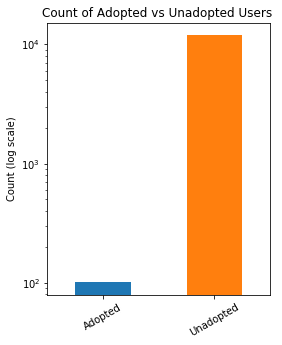

In [66]:
# Explore Feature Colinearity
_ = df1['adopted'].value_counts(ascending=True).plot(kind='bar', figsize=(4,5))
_ = plt.title('Count of Adopted vs Unadopted Users ')
_ = plt.xticks([0,1], ['Adopted', 'Unadopted'], rotation=30)
_ = plt.yscale('log')
_ = plt.ylabel('Count (log scale)')
plt.savefig('adopted_users.png');

In [18]:
print(int(df1['adopted'].sum()), ' users adopted, out of ', df1.shape[0],' total users.')

101  users adopted, out of  12000  total users.


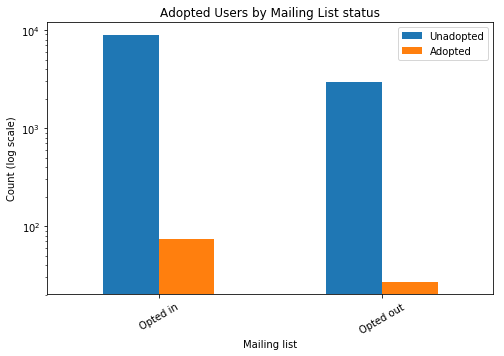

In [19]:
_ = pd.crosstab(df1['opted_in_to_mailing_list'], df1['adopted']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Adopted Users by Mailing List status')
_ = plt.xlabel('Mailing list')
_ = plt.xticks([0,1], ['Opted in','Opted out'], rotation=30)
_ = plt.ylabel('Count (log scale)')
_ = plt.yscale('log')
_ = plt.legend(['Unadopted', 'Adopted'])

- No obvious relationship between mailing list status and whether or not users adopted.

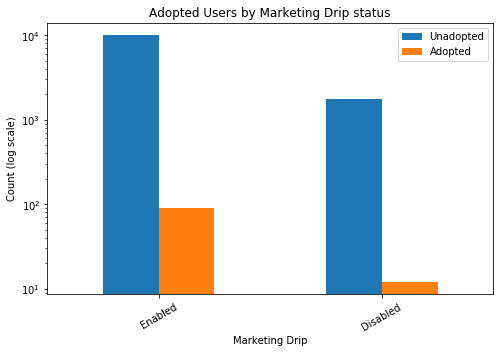

In [20]:
_ = pd.crosstab(df1['enabled_for_marketing_drip'], df1['adopted']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Adopted Users by Marketing Drip status')
_ = plt.xlabel('Marketing Drip')
_ = plt.xticks([0,1], ['Enabled','Disabled'], rotation=30)
_ = plt.ylabel('Count (log scale)')
_ = plt.yscale('log')
_ = plt.legend(['Unadopted', 'Adopted'])

- No obvious relationship between marketing drip status and whether or not users adopted.

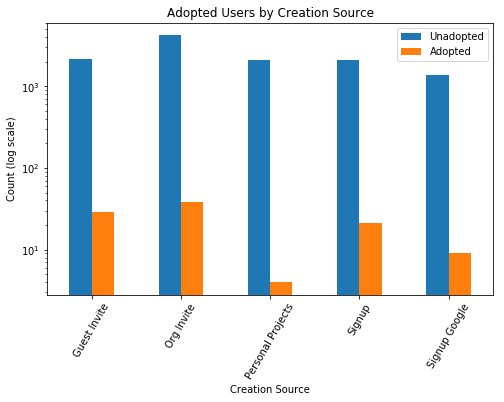

In [67]:
_ = pd.crosstab(df1['creation_source'], df1['adopted']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Adopted Users by Creation Source')
_ = plt.xlabel('Creation Source')
_ = plt.xticks([0,1, 2, 3, 4], ['Guest Invite','Org Invite', 'Personal Projects', 'Signup', 'Signup Google']
               , rotation=60)
_ = plt.ylabel('Count (log scale)')
_ = plt.yscale('log')
_ = plt.legend(['Unadopted', 'Adopted'])
plt.savefig('adoption_by_creation_source.png');

- `creation_source` appears to be a good predictor for adoption. 
- Users who **create their accounts via  GUEST_INVITE, ORG_INVITE, and SIGNUP are more likely to adopt** than those who create their account via PERSONAL_PROJECTS or SIGNUP_GOOGLE_AUTH.

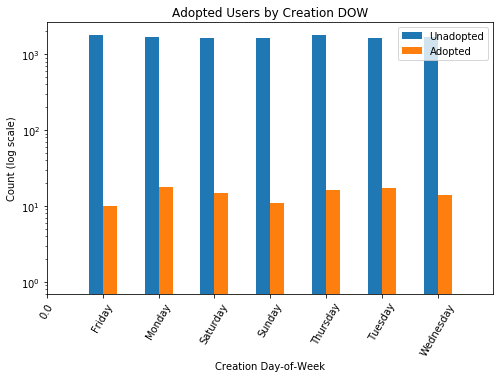

In [68]:
_ = pd.crosstab(df1['creation_dow'], df1['adopted']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Adopted Users by Creation DOW')
_ = plt.xlabel('Creation Day-of-Week')
_ = plt.xlim(0,8)
_ = plt.xticks(rotation=60)
_ = plt.ylabel('Count (log scale)')
_ = plt.yscale('log')
_ = plt.legend(['Unadopted', 'Adopted'])
plt.savefig('adoption_by_creation_dow.png');

- `creation_dow` appears to be a good predictor for adoption. 
- Users who **created their accounts on Monday, Tuesday, Wednesday, Thursday, and Saturday are more likely to adopt** than those who create their accounts on Friday or Sunday

### 5. Supervised Classification

Since the classes are imbalanced and most of the predictive variables are categorical, I will use a tree-based method.

In [69]:
# Set categoricals to dummy variables
df1_with_dummies = pd.get_dummies(df1, columns=['creation_source', 'creation_dow', 'org_id', 'invited_by_user_id'], drop_first=True)

In [70]:
# Define target and predictive variables
y = df1['adopted']

# Drop name and email from X because those are not things that can be leveraged.
# Drop last_session_creation_time and creation_time from X because it is not informative for 
# determining in advance whether a user will adopt. 
X = df1_with_dummies.drop(['adopted', 'last_session_creation_time', 'name', 'email', 'creation_time'], axis=1)

In [71]:
# Train-test split (70%-30%)
Xtrain, Xtest, ytrain, ytest = train_test_split(X.iloc[2:], y.iloc[2:], train_size=0.7, random_state=42)

In [72]:
ytrain.isnull().sum()

0

In [73]:
# Build classifier
rfc = RandomForestClassifier()
# Train
rfc.fit(Xtrain, ytrain)
# Predict
ypred = rfc.predict(Xtest)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [74]:
# Cast as integers so we can calculate metrics
ypred = (ypred>0.5).astype(int)
ytest = (ytest>0.5).astype(int)

In [80]:
# Calculate performance Metrics
print('Random Forest predicts on unseen data with', (accuracy_score(ytest, ypred))*100, '% accuracy.' )

Random Forest predicts on unseen data with 99.0555555556 % accuracy.


In [81]:
# Put the feature_importances_ in a dataframe
imp_feats = pd.DataFrame({'features':np.array(X.columns), 'importance':rfc.feature_importances_})
imp_feats.sort_values('importance', ascending=False, inplace=True)
imp_feats.head(10)

,features,importance
2,creation_source_ORG_INVITE,0.038983
8,creation_dow_Saturday,0.037862
0,opted_in_to_mailing_list,0.031750
7,creation_dow_Monday,0.031230
11,creation_dow_Tuesday,0.029947
9,creation_dow_Sunday,0.027663
4,creation_source_SIGNUP,0.026906
12,creation_dow_Wednesday,0.026780
6,creation_dow_Friday,0.024093
10,creation_dow_Thursday,0.020128
